In [2]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pylab as plt
import seaborn as sns
import os
import gensim
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap

In [3]:
links_2009 = pd.read_csv('./wikispeedia_paths-and-graph/links.tsv', delim_whitespace=True, names=['from', 'to'], comment='#')
links_2009.head()

,from,to
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


In [4]:
wikispeedia_paths = pd.read_csv('./wikispeedia_paths-and-graph/paths_finished.tsv', delim_whitespace=True,\
    names=['hashed_ip', 'timestamp', 'duration_sec', 'path', 'rating'], comment='#')

wikispeedia_paths.head()

,hashed_ip,timestamp,duration_sec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [5]:
graph_2009 = nx.DiGraph()

for l, r in links_2009.iterrows():
    graph_2009.add_edge(r['from'], r['to'])

print(f"The graph from 2009 has {graph_2009.number_of_nodes()} nodes and {graph_2009.number_of_edges()} edges")

The graph from 2009 has 4592 nodes and 119882 edges


In [6]:
graph_wikispeedia_paths = nx.DiGraph()

for l, r in wikispeedia_paths.iterrows():
    path = r['path'].split(';')
    for i in range(len(path)-1):
        graph_wikispeedia_paths.add_edge(path[i], path[i+1])

print(f"The graph constructed from the finished paths has {graph_wikispeedia_paths.number_of_nodes()}"
      f" nodes and {graph_wikispeedia_paths.number_of_edges()} edges")

The graph constructed from the finished paths has 4170 nodes and 55147 edges


In [7]:
MODEL_PATH_2009 = './models/n2v_2009.model'
if os.path.isfile(MODEL_PATH_2009):
    model_2009 = gensim.models.word2vec.Word2Vec.load(MODEL_PATH_2009)
else:
    n2v_2009 = Node2Vec(graph_2009, dimensions=128, walk_length=4, num_walks=2000, workers=8)
    model_2009 = n2v_2009.fit()
    model_2009.save(MODEL_PATH_2009)

model_2009.wv['Sweden']

array([-0.17008843, -0.35725003, -0.38356793,  0.6866923 ,  0.6738821 ,
       -0.12233853, -0.19395564,  0.15103446, -0.09715749,  0.03813872,
       -0.06951016, -0.256702  ,  0.36491325, -0.40205505, -0.2492647 ,
       -0.09414036,  0.10855879, -0.17133082, -0.42238778,  0.14083521,
       -0.0941226 , -0.01032163,  0.27214313, -0.6695063 , -0.02239629,
        0.4880574 , -0.14091873,  0.44702047, -0.44928017, -0.02059604,
        0.07622561, -0.14202608,  0.41775727, -0.06673474, -0.06219029,
        0.60700965,  0.35250312, -0.12095001, -0.02236387, -0.19755235,
       -0.28541636,  0.0340822 ,  0.19557181, -0.00722458,  0.5579651 ,
        0.37106982, -0.21122506,  0.3648612 , -0.18734476,  0.2256245 ,
        0.7639295 ,  0.85262096,  0.07151526,  0.27038813, -0.53205633,
       -0.3233472 , -0.12373018,  0.09515521,  0.4023855 ,  0.01277489,
       -0.45920318, -0.6146704 , -0.130397  , -0.17217669, -0.45271102,
       -0.43772373,  0.14640193, -0.08074398, -0.16542964, -0.20

In [8]:
MODEL_PATH_WIKISPEEDIA_PATHS = './models/n2v_wikispeedia_paths.model'
if os.path.isfile(MODEL_PATH_WIKISPEEDIA_PATHS):
    model_wikispeedia_paths = gensim.models.word2vec.Word2Vec.load(MODEL_PATH_WIKISPEEDIA_PATHS)
else:
    n2v_wikispeedia_paths = Node2Vec(graph_wikispeedia_paths, dimensions=128, walk_length=4, num_walks=2000, workers=8)
    model_wikispeedia_paths = n2v_wikispeedia_paths.fit()
    model_wikispeedia_paths.save(MODEL_PATH_WIKISPEEDIA_PATHS)

model_wikispeedia_paths.wv['Sweden']

Computing transition probabilities:   0%|          | 0/4170 [00:00<?, ?it/s]

Generating walks (CPU: 7):  87%|████████▋ | 217/250 [00:27<00:04,  7.73it/s]

array([ 0.01866122, -0.44111574, -0.01633382,  0.2516948 ,  0.6385212 ,
        0.17041612,  0.36247188,  0.4672955 , -0.15129723,  0.5810698 ,
        0.58998936,  0.2156789 , -0.09588185, -0.38893026,  0.16427504,
       -0.12866734,  0.10984562,  0.4058674 , -0.49440935,  0.7205736 ,
        0.19027965, -0.15742584,  0.1974396 , -0.58365774, -0.35076627,
       -0.19371139,  0.21024524,  0.160984  ,  0.3240786 ,  0.40876737,
       -0.55647534, -0.1156601 ,  0.14933424,  0.47653735, -0.7028484 ,
       -0.15289256,  0.30328208,  0.24985312, -0.11839057,  0.18157363,
        0.48651022, -0.9012341 , -0.27569708, -0.07578088, -0.2111661 ,
        0.6168125 , -0.16252173, -0.26403397, -0.26099274,  0.45208472,
        0.57781005,  0.00785645, -0.01486246,  0.22085018,  0.34347907,
       -0.09837431, -0.1692996 ,  0.38455188, -0.21390156,  0.46928504,
       -0.32779405, -0.0864339 , -0.13675547,  0.18146537, -0.2402159 ,
        0.12808295,  0.5928113 , -0.06016839, -0.02949668, -0.03

<AxesSubplot:>

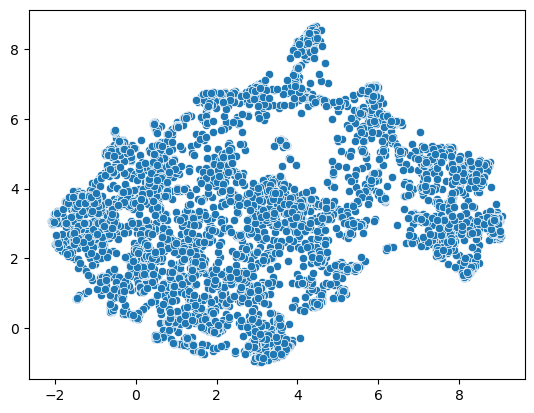

In [28]:
reducer = umap.UMAP()
embedding_2009 = reducer.fit_transform(model_2009.wv.get_normed_vectors())
embedding_2009.shape
sns.scatterplot(x=embedding_2009[:, 0], y=embedding_2009[:, 1])

<AxesSubplot:>

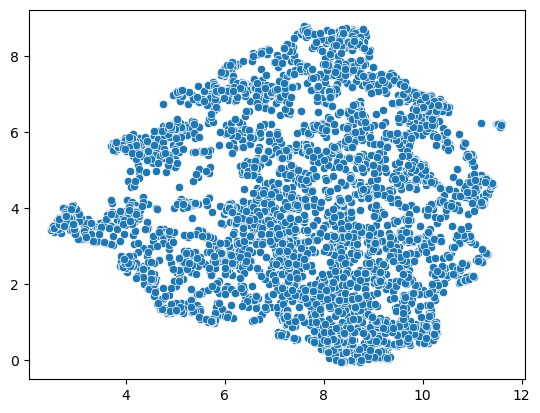

In [27]:
reducer = umap.UMAP()
embedding_wikispeedia_paths = reducer.fit_transform(model_wikispeedia_paths.wv.get_normed_vectors())
embedding_wikispeedia_paths.shape
sns.scatterplot(x=embedding_wikispeedia_paths[:, 0], y=embedding_wikispeedia_paths[:, 1])